In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load iris data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, header=None)
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
X = df.iloc[:, :-1].values


In [2]:
def normalize(X): return StandardScaler().fit_transform(X)
def apply_pca(X, n=2): return PCA(n_components=n).fit_transform(X)

In [3]:
def evaluate_clustering(X, labels):
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return sil, ch, db

def run_all_clustering(X, cluster_counts=[3, 4, 5]):
    results = {
        "method": [], "preprocessing": [], "clusters": [],
        "silhouette": [], "calinski": [], "davies": []
    }

    preprocessing_methods = {
        "None": X,
        "Normalized": normalize(X),
        "PCA": apply_pca(normalize(X)),
    }

    for preproc_name, X_prep in preprocessing_methods.items():
        for c in cluster_counts:
            # KMeans
            kmeans = KMeans(n_clusters=c, n_init=10, random_state=42)
            labels = kmeans.fit_predict(X_prep)
            s, ch, db = evaluate_clustering(X_prep, labels)
            results["method"].append("KMeans")
            results["preprocessing"].append(preproc_name)
            results["clusters"].append(c)
            results["silhouette"].append(s)
            results["calinski"].append(ch)
            results["davies"].append(db)

            # Hierarchical
            hc = AgglomerativeClustering(n_clusters=c)
            labels = hc.fit_predict(X_prep)
            s, ch, db = evaluate_clustering(X_prep, labels)
            results["method"].append("Hierarchical")
            results["preprocessing"].append(preproc_name)
            results["clusters"].append(c)
            results["silhouette"].append(s)
            results["calinski"].append(ch)
            results["davies"].append(db)

        # Mean Shift (no predefined c)
        if preproc_name != "PCA":
            bandwidth = estimate_bandwidth(X_prep, quantile=0.3)
            ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
            labels = ms.fit_predict(X_prep)
            if len(np.unique(labels)) > 1:
                s, ch, db = evaluate_clustering(X_prep, labels)
                results["method"].append("MeanShift")
                results["preprocessing"].append(preproc_name)
                results["clusters"].append(len(np.unique(labels)))
                results["silhouette"].append(s)
                results["calinski"].append(ch)
                results["davies"].append(db)

    return pd.DataFrame(results)


In [4]:
results_df = run_all_clustering(X)
results_df.sort_values(by=["method", "preprocessing", "clusters"], inplace=True)
results_df


,method,preprocessing,clusters,silhouette,calinski,davies
1,Hierarchical,None,3,0.554097,556.841122,0.656604
3,Hierarchical,None,4,0.488740,513.772164,0.795602
5,Hierarchical,None,5,0.484155,487.070341,0.820687
8,Hierarchical,Normalized,3,0.445540,220.260437,0.805940
10,Hierarchical,Normalized,4,0.399326,198.730315,0.981081
12,Hierarchical,Normalized,5,0.354970,194.961557,0.946529
15,Hierarchical,PCA,3,0.510294,283.107423,0.707180
17,Hierarchical,PCA,4,0.460304,253.908112,0.710474
19,Hierarchical,PCA,5,0.411581,254.987342,0.781780
0,KMeans,None,3,0.552592,560.399924,0.662323


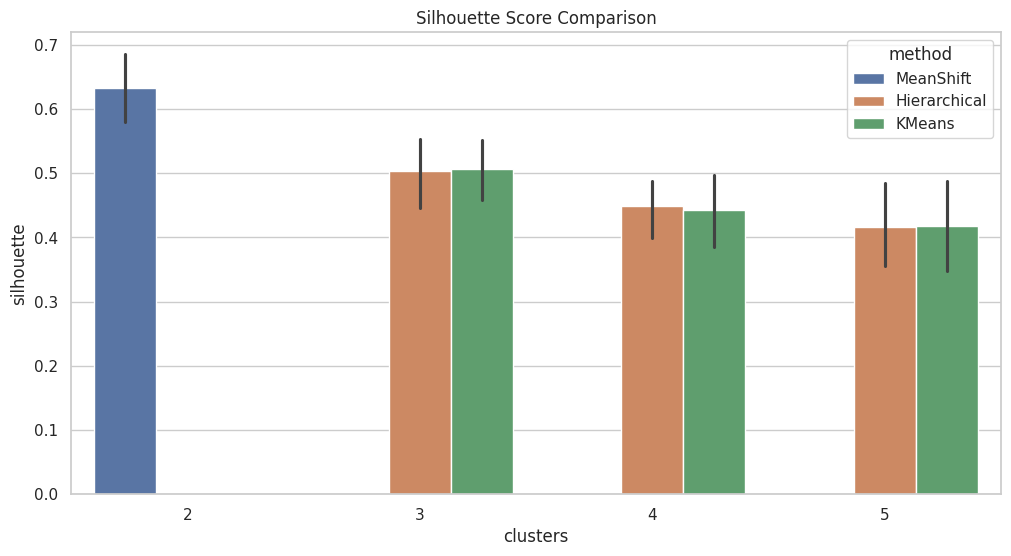

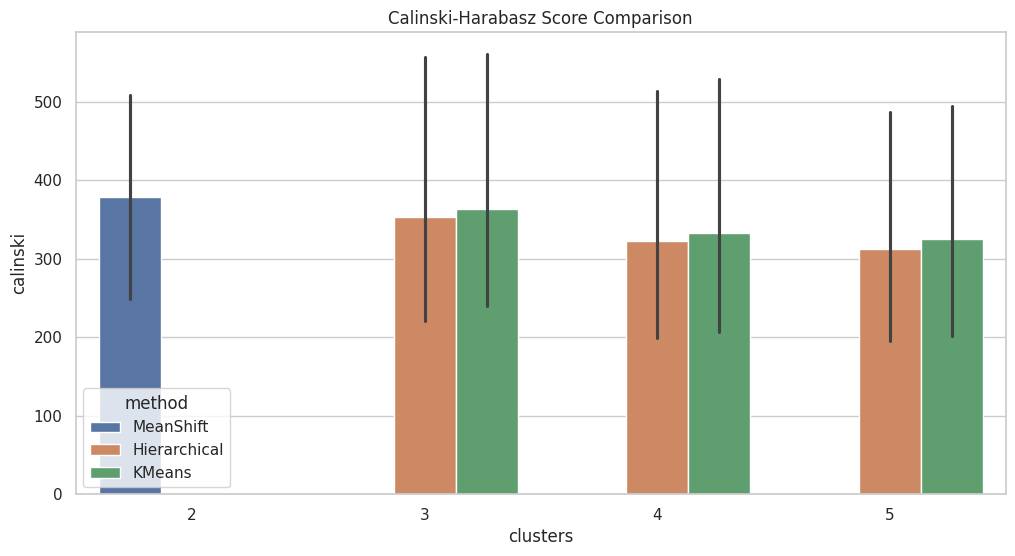

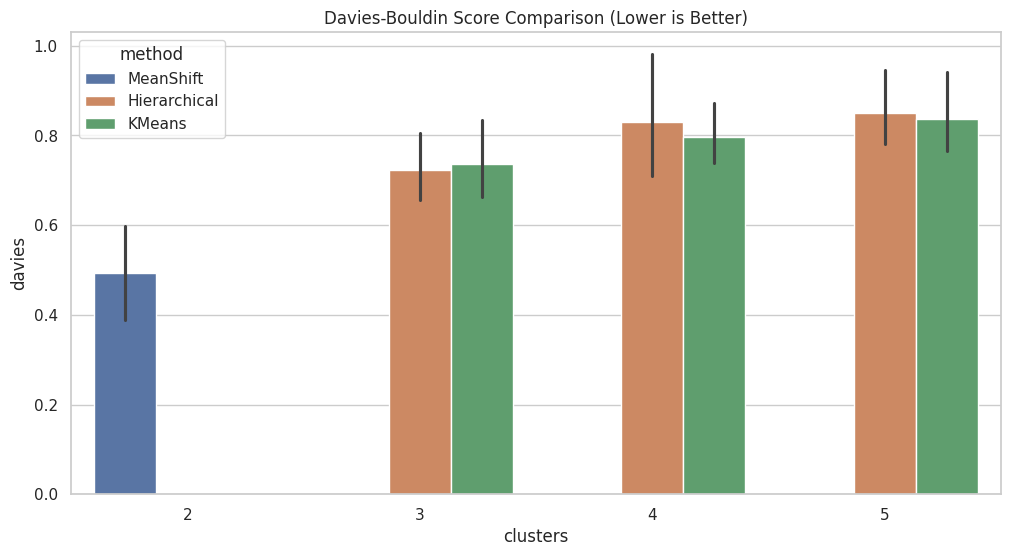

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="clusters", y="silhouette", hue="method")
plt.title("Silhouette Score Comparison")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="clusters", y="calinski", hue="method")
plt.title("Calinski-Harabasz Score Comparison")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="clusters", y="davies", hue="method")
plt.title("Davies-Bouldin Score Comparison (Lower is Better)")
plt.show()
